# Generative Adversarial Networks

<img src="GAN.JPG">

In [1]:
#노이즈 z = 128, 등의 랜덤값을 넣어 0~9까지의 fake data생성
#discriminator에 input이 2번 들어감 교차해서 배치하듯이 들어감

## Download MNIST and load it

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import shutil

from keras.datasets import mnist
(train_data, train_label), (test_data, test_label) = mnist.load_data()
train_data = train_data / 255.
test_data = test_data / 255.

def img_tile(imgs, aspect_ratio=1.0, tile_shape=None, border=1,
             border_color=0):
    ''' Tile images in a grid.
    If tile_shape is provided only as many images as specified in tile_shape
    will be included in the output.
    '''
    imgs = np.array(imgs)
    if imgs.ndim != 3 and imgs.ndim != 4:
        raise ValueError('imgs has wrong number of dimensions.')
    n_imgs = imgs.shape[0]

    # Grid shape
    img_shape = np.array(imgs.shape[1:3])
    if tile_shape is None:
        img_aspect_ratio = img_shape[1] / float(img_shape[0])
        aspect_ratio *= img_aspect_ratio
        tile_height = int(np.ceil(np.sqrt(n_imgs * aspect_ratio)))
        tile_width = int(np.ceil(np.sqrt(n_imgs / aspect_ratio)))
        grid_shape = np.array((tile_height, tile_width))
    else:
        assert len(tile_shape) == 2
        grid_shape = np.array(tile_shape)

    # Tile image shape
    tile_img_shape = np.array(imgs.shape[1:])
    tile_img_shape[:2] = (img_shape[:2] + border) * grid_shape[:2] - border

    # Assemble tile image
    tile_img = np.empty(tile_img_shape)
    tile_img[:] = border_color
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            img_idx = j + i * grid_shape[1]
            if img_idx >= n_imgs:
                # No more images - stop filling out the grid.
                break
            img = imgs[img_idx]
            yoff = (img_shape[0] + border) * i
            xoff = (img_shape[1] + border) * j
            tile_img[yoff:yoff + img_shape[0], xoff:xoff + img_shape[1], ...] = img

    return tile_img


def plot_network_output(data, reconst_data, generated, step):
    num = 8
    
    fig, ax = plt.subplots(nrows=3, ncols=num, figsize=(18, 6))
    for i in xrange(num):
        ax[(0, i)].imshow(np.squeeze(generated[i]), cmap=plt.cm.gray)
        ax[(1, i)].imshow(np.squeeze(data[i]), cmap=plt.cm.gray)
        ax[(2, i)].imshow(np.squeeze(reconst_data[i]), cmap=plt.cm.gray)
        ax[(0, i)].axis('off')
        ax[(1, i)].axis('off')
        ax[(2, i)].axis('off')

    fig.suptitle('Top: generated | Middle: data | Bottom: recunstructed')
#     plt.show()
    plt.savefig(IMAGE_DIR + '/{}.png'.format(str(step).zfill(6)))
    plt.close()

Using TensorFlow backend.


## show MNIST

In [3]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


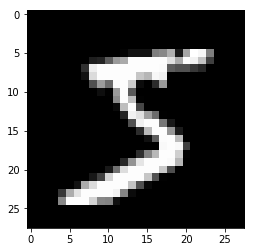

In [4]:
plt.imshow(train_data[0], 'gray')

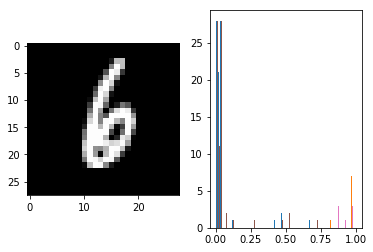

In [5]:
# show data
idx = np.random.randint(0, train_data.shape[0])
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[idx]
# ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax1.imshow(np.array(sample_data*255, dtype=np.uint8), 'gray')
ax2.hist(sample_data, bins=20, range=[0, 1]);

## Delete summary folder and make it

In [6]:
SUMMARY_DIR = './gan_summary'
TRAIN_DIR = SUMMARY_DIR + '/train'
TEST_DIR = SUMMARY_DIR + '/test'
IMAGE_DIR = SUMMARY_DIR + '/image'

if os.path.exists(SUMMARY_DIR):
    shutil.rmtree(SUMMARY_DIR)
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)
    os.makedirs(TRAIN_DIR)
    os.makedirs(TEST_DIR)
    os.makedirs(IMAGE_DIR)

## Define tensorflow graph

In [7]:
# index 추출
test = tf.placeholder(tf.float32, shape=[10, 128], name='test')
# test.shape.as_list()[1]
test.get_shape().as_list()[1]

128

In [8]:
def fully_connected(inputs, out_channel, name='fc'):
    """
    very simple fully connected layer function

    Args:
        inputs: a batch of input tensor [batch_size, n]
                where n is the number of input feature dimension
        out_channel: output channel dimension

    Returns:
        fc: inputs * weights + biases [batch_size, out_channel]
    """
    # Define weight matrix variable, bias vector variable
    with tf.variable_scope(name):
        # To share the variables you have to use
        # a function 'tf.get_variable' instead of 'tf.Variable'
        
        # [batch_size, n] * [, ] = [batch_size, out_channel]
        # weight [n, out_channel]
        
        weights = tf.get_variable('w', 
                    shape = [inputs.shape.as_list()[1], out_channel],
                    initializer = tf.initializers.truncated_normal(stddev=0.01))
#                     initializer = tf.initializers.glorot_normal #sigmoid
#                     initializer = tf.initializers.he_normal #ReLU
            #다른 이니셜라이져
        
        biases = tf.get_variable('b', 
                    shape = [out_channel],
                    initializer = tf.initializers.zeros)
        
        # n * out_channel
        
        fc = inputs @ weights + biases # @: matirix product
#         fc = tf.matmul(inputs,weights) + biases
        
#         fc = tf.matmul(inputs,weights)
#         fc = tf.nn.add_bias(fc,biases)
#         fc = inputs * weights + biases # 는 eliment product일 수 있음
        return fc


def discriminator(x, reuse=None):
    """
    build the discriminator

    Args:
        x: a batch of input to the network [batch_size, 28, 28, 1]

    returns:
        net: output of the discriminator [batch_size, 1]
    """
    with tf.variable_scope('discriminator') as scope:
        if reuse: #reuse가 들어와서 fully_connected가 들어오면 아까 fc1의 variable이 호출됨
            scope.reuse_variables()

        # Vectorize the input x
        # Fully connected layer with 256 output units and 'fc1' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 1 output units and 'fc2' as its name
        # Apply non-linearity function 'sigmoid'
        # Return the final tensor
        net = tf.reshape(x, [-1, 28*28*1]) #batch_size에 -1
        net = fully_connected(net, 256, 'fc1')
        net = tf.nn.relu(net)
        net = fully_connected(net, 1, 'fc2') # fc함수 2개 들어가면 get_variable을 기존에 만든 것을 참조, size도 다름
                                             # 따라서 뒤에 name 인자 다르게 추가
        net = tf.nn.sigmoid(net)
        
        return net


def generator(z):
    """
    build the generator

    Args:
        z: a batch of input to the network [batch_size, z_dim]
        #z_dim은 노이즈, 하이퍼 파라미터
    Returns:
        net: output of the generator [batch_size, 28, 28, 1]
    """
    with tf.variable_scope('generator') as scope:

        # Unlike the discriminator, input z is a set of vectors
        
        # Fully connected layer with 256 output units and 'fc1' as its name
        # Apply non-linearity function 'relu'
        # Fully connected layer with 784 output units and 'fc2' as its name
        # Apply non-linearity function 'sigmoid'
        # Reshape final output to be a proper image file [28, 28, 1]
        # Return the final tensor
        
        net = fully_connected(z, 256, 'fc1') #같은 fc1이여도 variable scope 이름이 달라서 괜찮음
        net = tf.nn.relu(net)
        net = fully_connected(net, 784, 'fc2')
        net = tf.sigmoid(net)
        net = tf.reshape(net, [-1, 28, 28, 1])
        
        #역 순으로 짠다
        
        return net


def get_loss(D_real, D_fake, eps=1e-10):
    """
    get loss of GAN

    Args:
        D_real: Real Discriminator output [batch_size, 1]
        D_rake: Fake discriminator output [batch_size, 1]

    Returns:
        D_loss: Discriminator loss
        G_loss: Generator loss
    """
    D_loss = -(tf.reduce_mean( tf.log(D_real + eps) + tf.log(1 - D_fake + eps) )) #batch_size 원소 수만큼의 평균
            #밑의 minimize
#     G_loss = tf.reduce_mean( tf.log(1 - D_fake + eps) ) #minimize
    G_loss = -(tf.reduce_mean( tf.log(D_fake + eps) )) #maximize 처음에 랜덤노이즈때문에 거의 discriminator가 작동을 잘함
    # 거의 D_fake가 0에 가까움 gradient가 작음. 해당함수로 쓰면 기울기가 커져서 step_size가 커져서 빠르게 학습을 잘함
    
    return D_loss, G_loss


def get_next_batch(data, label, batch_size):
    """
    get 'batch_size' amount of data and label randomly

    Args:
        data: data
        label: label
        batch_size: # of data to get

    Returns:
        batch_data: data of 'batch_size'
        batch_label: coresponding label of batch_data
    """
    n_data = data.shape[0]
    random_idx = random.sample(range(1, n_data), batch_size)

    batch_data = data[random_idx]
    batch_label = label[random_idx]
    return batch_data, batch_label


# Set hyperparameters
batch_size = 100
z_dim = 128
max_step = 10000
lr = 0.008
beta1 = 0.68

train_data = np.expand_dims(train_data, 3)
test_data = np.expand_dims(test_data, 3)

############################# Build the model #############################구현에 핵심이 되는 구간 빈 칸 뚫을 수도
# Define image tensor x placeholder
x = tf.placeholder(tf.float32, [batch_size, 28, 28, 1], name='input_x') #batch_size에 -1이나 None넣으면 변한다는 뜻
# Define z vector as uniform distribution between [-1, 1]
z = tf.random_uniform((batch_size, z_dim), -1., 1., name='latent_z') #z를 부를 때 마다 random constant

# Build discriminator where input data is real image x
D_real = discriminator(x, reuse=False) #bulid과정에서 get_variable을 만들어야 함
# Build generator
G = generator(z)
# Build discriminator where input data is generated image G
D_fake = discriminator(G, reuse=True) #똑같은 discriminator에서 만들어둔 get_variable(w,b)을 그대로 써야함
# Get D_loss and G_loss
D_loss, G_loss = get_loss(D_real, D_fake)

# Make optimization op
opt = tf.train.AdamOptimizer(lr, beta1=beta1)

# To update the generator and the discriminator
# get their network parameters
G_params = [param for param in tf.trainable_variables()
            if 'generator' in param.name]
D_params = [param for param in tf.trainable_variables()
            if 'discriminator' in param.name]

# Make train op for each network
D_train = opt.minimize(D_loss, var_list=D_params) #var_list :back_prop, update할때 해당 인자들만 update하겠다고 지정
G_train = opt.minimize(G_loss, var_list=G_params)

# Make initialization op
init = tf.global_variables_initializer()

# Add summary and make op to add summary data to event log
tf.summary.scalar('Generator_loss', G_loss)
tf.summary.scalar('Discriminator_loss', D_loss)
merged = tf.summary.merge_all()

## Train GAN

Training data


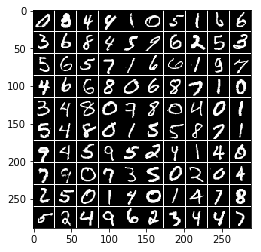

0 steps |  G_loss: 0.9928, D_loss: 1.3879


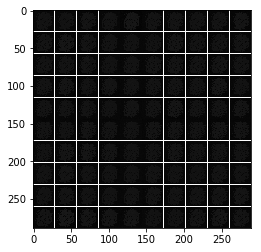

200 steps |  G_loss: 3.8757, D_loss: 0.6049


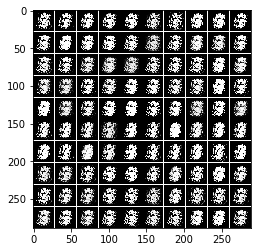

400 steps |  G_loss: 3.1807, D_loss: 0.6054


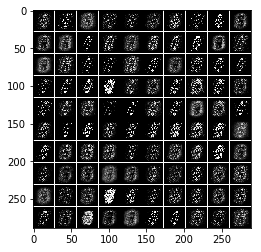

600 steps |  G_loss: 3.3942, D_loss: 1.4422


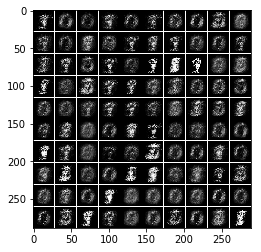

800 steps |  G_loss: 2.0072, D_loss: 0.9784


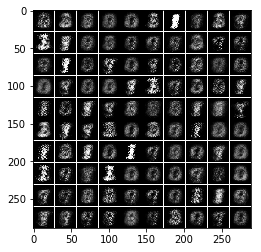

1000 steps |  G_loss: 2.6603, D_loss: 0.8060


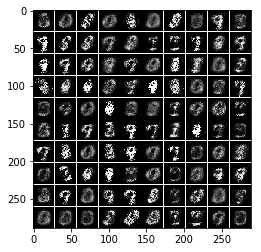

1200 steps |  G_loss: 2.3172, D_loss: 0.7662


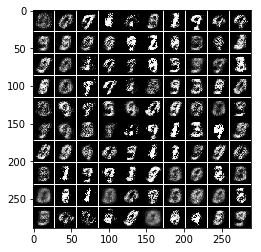

1400 steps |  G_loss: 1.9310, D_loss: 1.2466


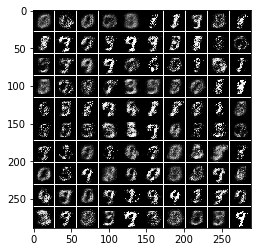

1600 steps |  G_loss: 1.3182, D_loss: 1.3820


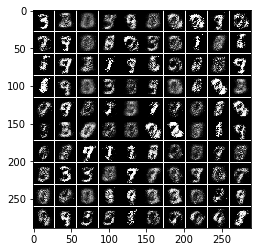

1800 steps |  G_loss: 1.4862, D_loss: 1.2061


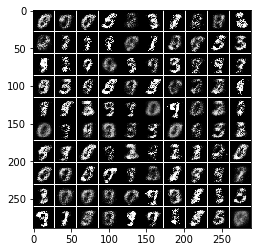

2000 steps |  G_loss: 1.4961, D_loss: 1.2713


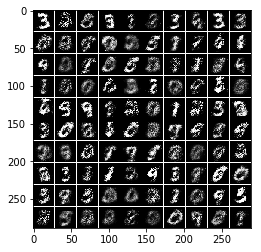

2200 steps |  G_loss: 1.3099, D_loss: 1.0972


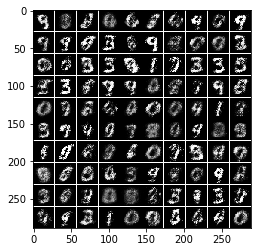

2400 steps |  G_loss: 1.3342, D_loss: 1.1226


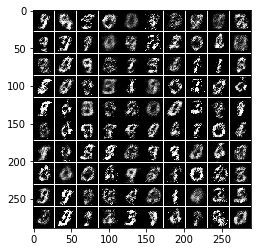

2600 steps |  G_loss: 0.9119, D_loss: 1.1605


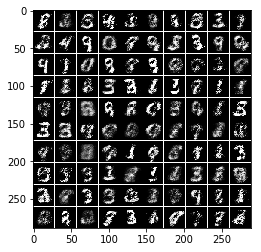

2800 steps |  G_loss: 0.8794, D_loss: 1.3539


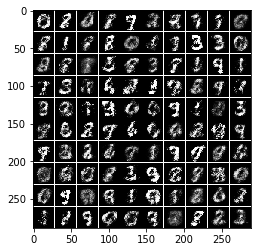

3000 steps |  G_loss: 1.2136, D_loss: 1.2185


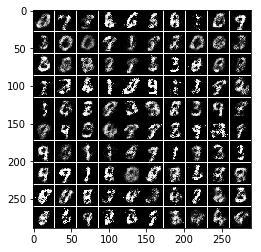

3200 steps |  G_loss: 1.3439, D_loss: 1.3027


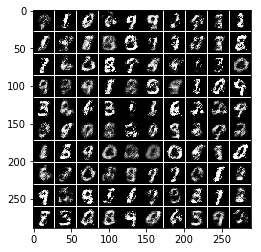

3400 steps |  G_loss: 1.3408, D_loss: 1.4123


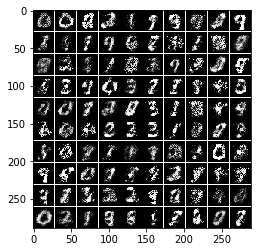

3600 steps |  G_loss: 1.1755, D_loss: 1.1819


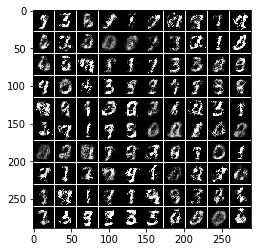

3800 steps |  G_loss: 0.9920, D_loss: 1.2151


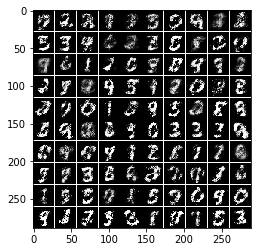

4000 steps |  G_loss: 0.9197, D_loss: 1.1350


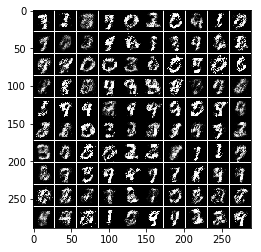

4200 steps |  G_loss: 0.9160, D_loss: 1.1859


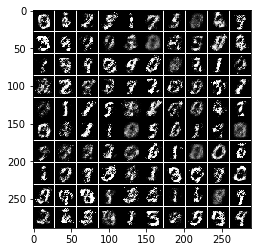

4400 steps |  G_loss: 0.9551, D_loss: 1.2763


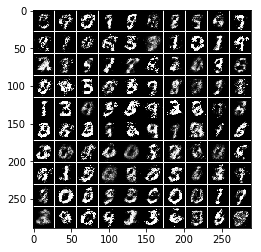

4600 steps |  G_loss: 1.0153, D_loss: 1.4286


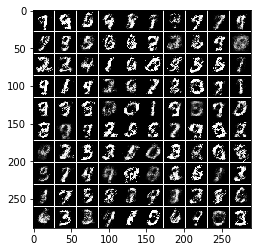

4800 steps |  G_loss: 1.0845, D_loss: 1.2952


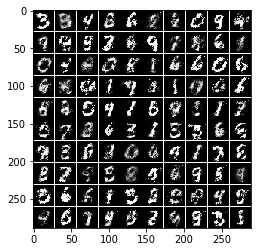

5000 steps |  G_loss: 0.9597, D_loss: 1.3200


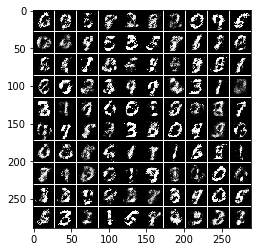

5200 steps |  G_loss: 0.9288, D_loss: 1.1528


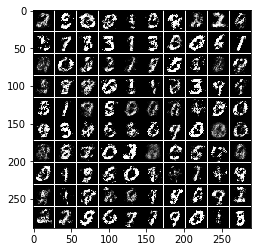

5400 steps |  G_loss: 1.1322, D_loss: 1.1773


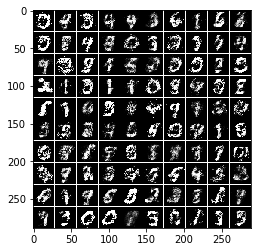

5600 steps |  G_loss: 1.0980, D_loss: 1.2773


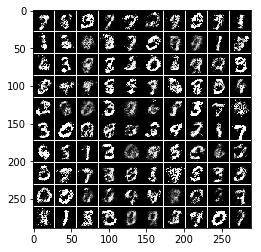

5800 steps |  G_loss: 1.1366, D_loss: 1.2322


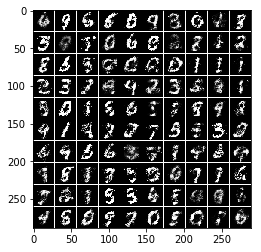

6000 steps |  G_loss: 1.1693, D_loss: 0.9817


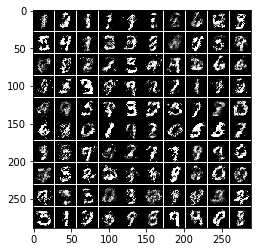

6200 steps |  G_loss: 1.1343, D_loss: 1.1843


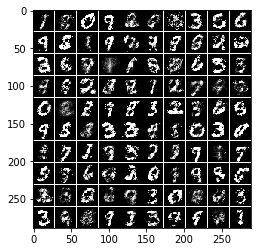

6400 steps |  G_loss: 1.1330, D_loss: 1.1993


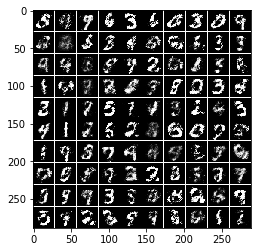

6600 steps |  G_loss: 1.3284, D_loss: 1.0104


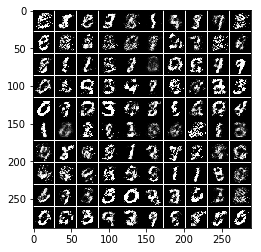

6800 steps |  G_loss: 1.3301, D_loss: 1.0560


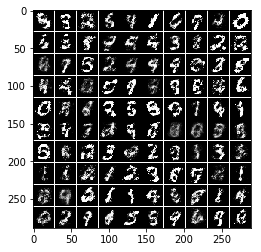

7000 steps |  G_loss: 1.3636, D_loss: 1.1930


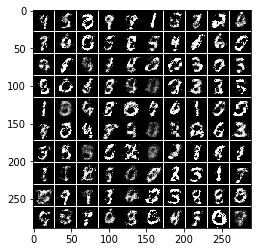

7200 steps |  G_loss: 1.3226, D_loss: 1.1355


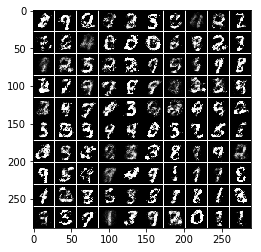

7400 steps |  G_loss: 1.1196, D_loss: 1.2908


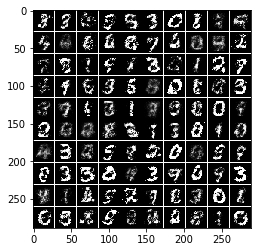

7600 steps |  G_loss: 1.0642, D_loss: 1.1826


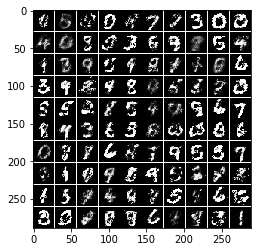

7800 steps |  G_loss: 1.2401, D_loss: 1.1278


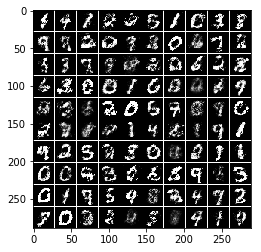

8000 steps |  G_loss: 1.3134, D_loss: 1.1362


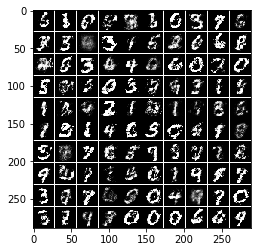

8200 steps |  G_loss: 1.2322, D_loss: 1.1295


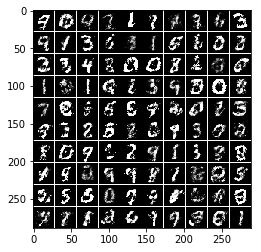

8400 steps |  G_loss: 1.5924, D_loss: 1.1206


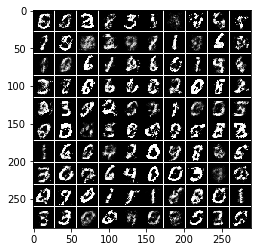

8600 steps |  G_loss: 1.3618, D_loss: 1.1267


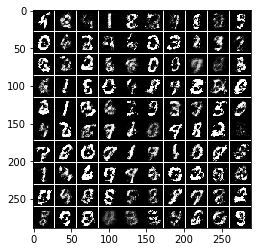

8800 steps |  G_loss: 1.1345, D_loss: 1.1242


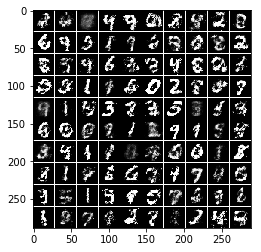

9000 steps |  G_loss: 1.0579, D_loss: 1.1352


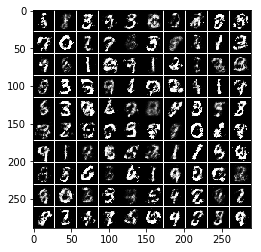

9200 steps |  G_loss: 1.2999, D_loss: 1.0799


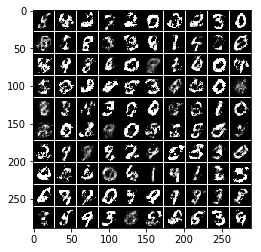

9400 steps |  G_loss: 1.4109, D_loss: 1.1240


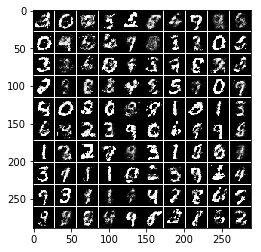

9600 steps |  G_loss: 1.2290, D_loss: 1.2549


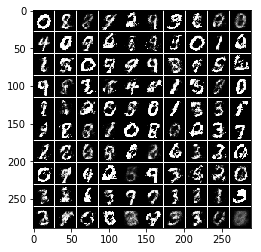

9800 steps |  G_loss: 1.6507, D_loss: 1.0032


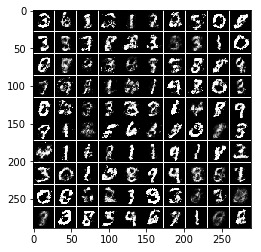

In [9]:
with tf.Session() as sess:
    # Define writer
    train_writer = tf.summary.FileWriter(TRAIN_DIR, sess.graph)
    test_writer = tf.summary.FileWriter(TEST_DIR)
    
    # Initialize variables
    sess.run(init)
    
    # Before train the model, shows train data and save it
    batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
    train_tiled = img_tile(batch_x, border_color=1.0)
    train_tiled = np.squeeze(train_tiled)
    print("Training data")
    plt.imshow(train_tiled, cmap=plt.cm.gray)
    plt.show()
    plt.imsave(IMAGE_DIR + '/train.png', train_tiled, cmap=plt.cm.gray)
    
    samples = []
    for step in range(max_step):
        batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
        
        _, d_loss = sess.run([D_train, D_loss], feed_dict={x: batch_x})
        _, g_loss = sess.run([G_train, G_loss])
        summary = sess.run(merged, feed_dict={x: batch_x})
        train_writer.add_summary(summary, step)
        
        # Save generarted data to make gif files
        if step % 50 == 0:
            g = sess.run(G)
            g_tiled = img_tile(g, border_color=1.0)
            g_tiled = np.squeeze(g_tiled)
            samples.append(g_tiled)
        if step % 200 == 0:
            print("{} steps |  G_loss: {:.4f}, D_loss: {:.4f}".format(step, g_loss, d_loss))
            plt.imshow(g_tiled, cmap=plt.cm.gray)
            plt.show()
            plt.imsave(IMAGE_DIR + '/{}.png'.format(str(step).zfill(6)),
                       g_tiled, cmap=plt.cm.gray)
#             plt.close()



In [10]:
import imageio
# Make gif files
imageio.mimsave(SUMMARY_DIR + '/generated.gif', samples)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0